# Group 10 - First Year Project 
### Data Science at ITU 
## Project 1 - Road collisions analysis 2021 

The first project of Data Science's second semester required us to inform various city leaders around the United Kingdom about traffic fatalities and injuries; and give some insight for urban transport planning. This jupyter notebook presents Group 10's exploration of 2019 UK road collision data with complimentary analysis, visualisation and findings with relation to the city of Sheffield.


# Task 0

## Loading data
Our first task invovles loading our 3 csv files (downloaded from https://data.gov.uk/dataset/road-accidents-safety-data on the 4th January 2021) into a traversable data structure we can start working with; such as a dictionary. We will then need to start the process of filtering and cleaning our data.

In [3]:
import numpy as np
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
import math
from scipy.stats import chi2_contingency

In [4]:
raw_data = {}

TITLES = ['accidents', 'casualties', 'vehicles'] # Capitalisation is the standard for constants

Pandas has a convinient method for reading in csv files and storing the data in a DataFrame structure offers flexibility.

In [5]:
raw_data['accidents'] = pd.read_csv("../data/raw/Road Safety Data - Accidents 2019.csv", dtype = None, encoding='utf-8-sig')
raw_data['casualties'] = pd.read_csv("../data/raw/Road Safety Data - Casualties 2019.csv", dtype = None, encoding='utf-8-sig')
raw_data['vehicles'] = pd.read_csv("../data/raw/Road Safety Data- Vehicles 2019.csv", dtype = None, encoding='utf-8-sig') # File name missing a space before hyphen 

C:\Users\Ruben PC\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (0,31) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
C:\Users\Ruben PC\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [6]:
for TITLE in TITLES:
    print(TITLE + "\tDataFrame shape: " + str(raw_data[TITLE].shape))

accidents	DataFrame shape: (117536, 32)
casualties	DataFrame shape: (153158, 16)
vehicles	DataFrame shape: (216381, 23)


 ### Data type insight?

In [7]:
#todo #DO IT FASTER

## Locating our city
With our data loaded into a dictionary of DataFrames, we needed to locate the accidents that occured in Sheffield. To do this we made a mask identifying which accidents occured in the local district authority 215.


In [8]:
sheffield_mask = (raw_data['accidents']["Local_Authority_(District)"] == 215)

In [9]:
sheffield_data = {}

sheffield_data['accidents'] = raw_data['accidents'][sheffield_mask]
sheffield_data['accidents'][:5]

,Accident_Index,Location_Easting_OSGR,Location_Northing_OSGR,Longitude,Latitude,Police_Force,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,Date,...,Pedestrian_Crossing-Human_Control,Pedestrian_Crossing-Physical_Facilities,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Special_Conditions_at_Site,Carriageway_Hazards,Urban_or_Rural_Area,Did_Police_Officer_Attend_Scene_of_Accident,LSOA_of_Accident_Location
44673,2019140805407,429140.0,381931.0,-1.563884,53.333509,14,2,2,1,01/01/2019,...,0,0,1,1,2,0,0,2,1,E01007926
44674,2019140805409,434290.0,385121.0,-1.486208,53.361875,14,3,2,1,01/01/2019,...,0,0,4,1,1,0,0,1,1,E01008052
44676,2019140805414,435393.0,391745.0,-1.468895,53.421340,14,1,1,1,01/01/2019,...,0,1,4,1,1,0,0,1,1,E01008123
44677,2019140805567,433949.0,396778.0,-1.490081,53.466672,14,2,2,1,01/01/2019,...,0,0,1,1,1,0,0,1,1,E01007901
44680,2019140805955,433662.0,389819.0,-1.495146,53.404142,14,3,2,1,03/01/2019,...,0,0,1,1,1,0,0,1,2,E01008093


In [10]:
sheffield_data['accidents'].shape

(909, 32)

We can now see that there are 909 records of road traffic accidents occuring in Sheffield over 2019. The next step was using the primary key (accident_index) of the accidents to find the accidents in Sheffield that each casualty and vehicle linked to, in order to complete our sheffield_data dictionary.

In [11]:
sheffield_data['accidents']["Accident_Index"][:5]

44673    2019140805407
44674    2019140805409
44676    2019140805414
44677    2019140805567
44680    2019140805955
Name: Accident_Index, dtype: object

In [12]:
for TITLE in TITLES[1:]: 
    sheffield_data[TITLE] = raw_data[TITLE][raw_data[TITLE]['Accident_Index'
                                                           ].isin(sheffield_data["accidents"]["Accident_Index"])]

We can now find out the number of rows and columns in our Sheffield data set

In [13]:
for TITLE in TITLES:
    print("Sheffield " + TITLE + "\tDataFrame shape: " + str(sheffield_data[TITLE].shape))

Sheffield accidents	DataFrame shape: (909, 32)
Sheffield casualties	DataFrame shape: (1191, 16)
Sheffield vehicles	DataFrame shape: (1648, 23)


There is 909 accidents each with 32 attributes.
There is 1191 casualties that occured in the 909 accidents each with 16 attributes.
There is 1648 vehicles that occured in the 909 accidents each with 23 attributes.

This indicates that some accidents involved more than one car, which logically makes sense. If there were a 1:1 ratio between accidents and vehicles, all the vehicles had driven into a object and not caused another vehicle to be part of the accident.

Creating the data files containing only the data from Sheffield

In [14]:
sheffield_data["accidents"].to_csv("../data/processed/sheffield_accidents.csv")
sheffield_data["vehicles"].to_csv("../data/processed/sheffield_vehicles.csv")
sheffield_data["casualties"].to_csv("../data/processed/sheffield_casualties.csv")

## Relational data table model 
In terms of the structure of the three databases or data tables, the accidents table's primary key is used as a foreign key by both the casualties and vehicles data tables, creating a one-to-many link between the accidents and both the casualties and vehicles tables. From this data table structure, we can infer that multiple casualties and vehicles can be involved in a single accident; which makes sense logically.

## Sanity check
Performing a sanity check on our Sheffield road accident data is a critical first step before we can begin to think about further analysing or drawing conclusions from the data. We may also have to sanity check all the data if we wish to draw conclusions therefrom.

In [15]:
#Check for empty strings in categorical fields  
#Check for NULL values                          #DONE more efficient method probably possible with michaels method (command line)
#Check duplicate records                        #DONE
#Check non-linked records in secondary tables   

### Checking for null values in our road accident dataset

In [16]:
flag = False
for TITLE in TITLES:
    if raw_data[TITLE].isnull().values.any():
        for column in list(raw_data[TITLE].columns):
            nulls = sum(raw_data[TITLE][column].isnull())
            if sum(raw_data[TITLE][column].isnull()):
                print(TITLE + " - " + column + "\t has " + str(nulls) + " null values")
                flag = True
if not flag: print("There are no null values in the dataset")

accidents - Location_Easting_OSGR	 has 28 null values
accidents - Location_Northing_OSGR	 has 28 null values
accidents - Longitude	 has 28 null values
accidents - Latitude	 has 28 null values
accidents - Time	 has 63 null values
accidents - LSOA_of_Accident_Location	 has 5714 null values


### Checking for null values in our sheffield dataset

In [17]:
flag = False
for TITLE in TITLES:
    if sheffield_data[TITLE].isnull().values.any():
        for column in list(sheffield_data[TITLE].columns):
            nulls = sum(sheffield_data[TITLE][column].isnull())
            if sum(sheffield_data[TITLE][column].isnull()):
                print(TITLE + " - " + column + "\t has " + str(nulls) + " null values")
                flag = True
if not flag: print("There are no null values in the dataset")

There are no null values in the dataset


### Checking for repeated indexes in our sheffield dataset

In [18]:
if len(sheffield_data["accidents"]["Accident_Index"]) == len((sheffield_data["accidents"]["Accident_Index"].unique())):
    print("No repeated indexes")
else: print("Repeated indexes detected")

No repeated indexes


C:\Users\Ruben PC\anaconda3\lib\site-packages\pandas\core\frame.py:4166: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


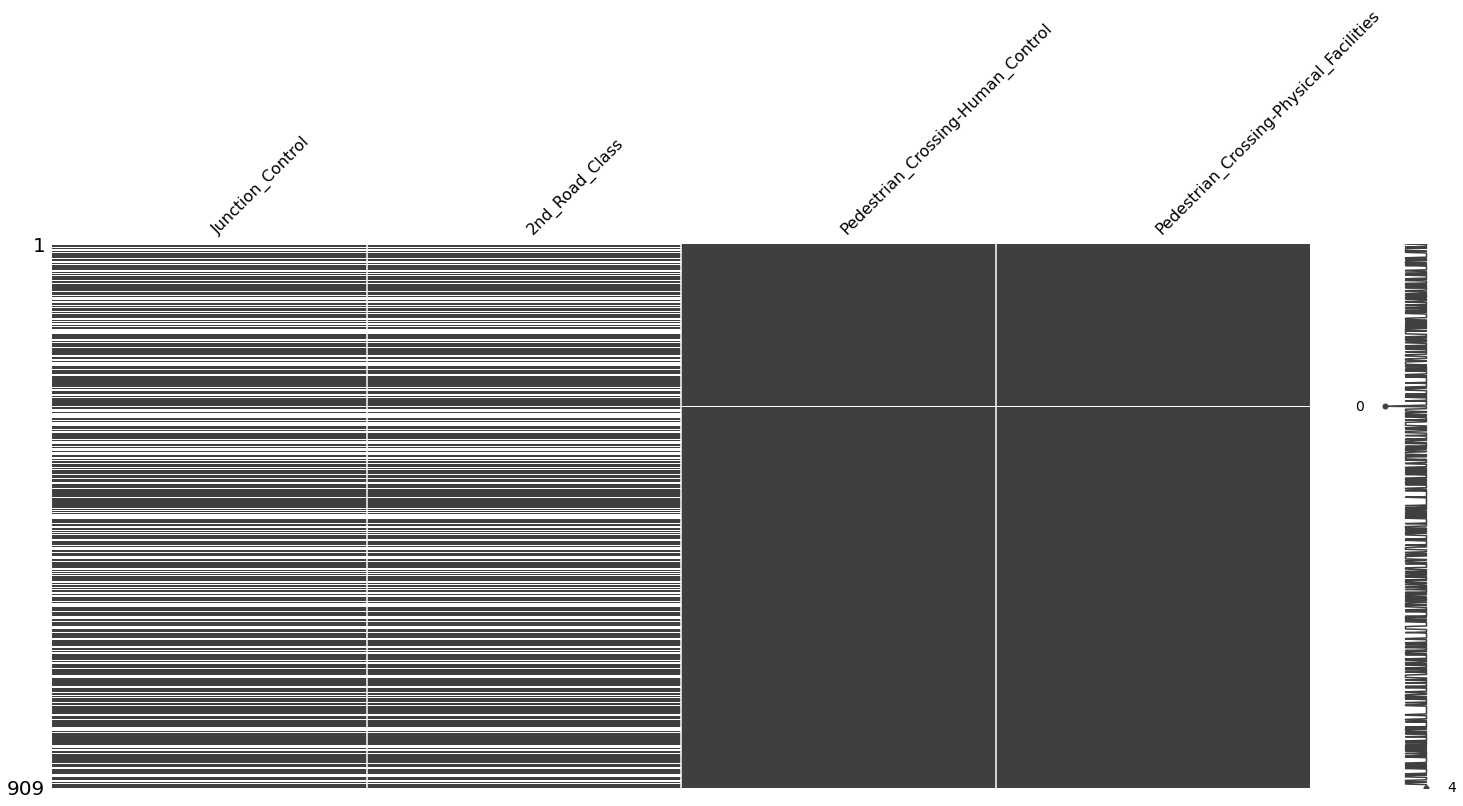

In [19]:
###NOT FULLY WORKING
sheffield_data["accidents"].replace(-1, np.nan, inplace=True)
missingdata_df = sheffield_data["accidents"].columns[sheffield_data["accidents"].isnull().any()].tolist()
msno.matrix(sheffield_data["accidents"][missingdata_df]);

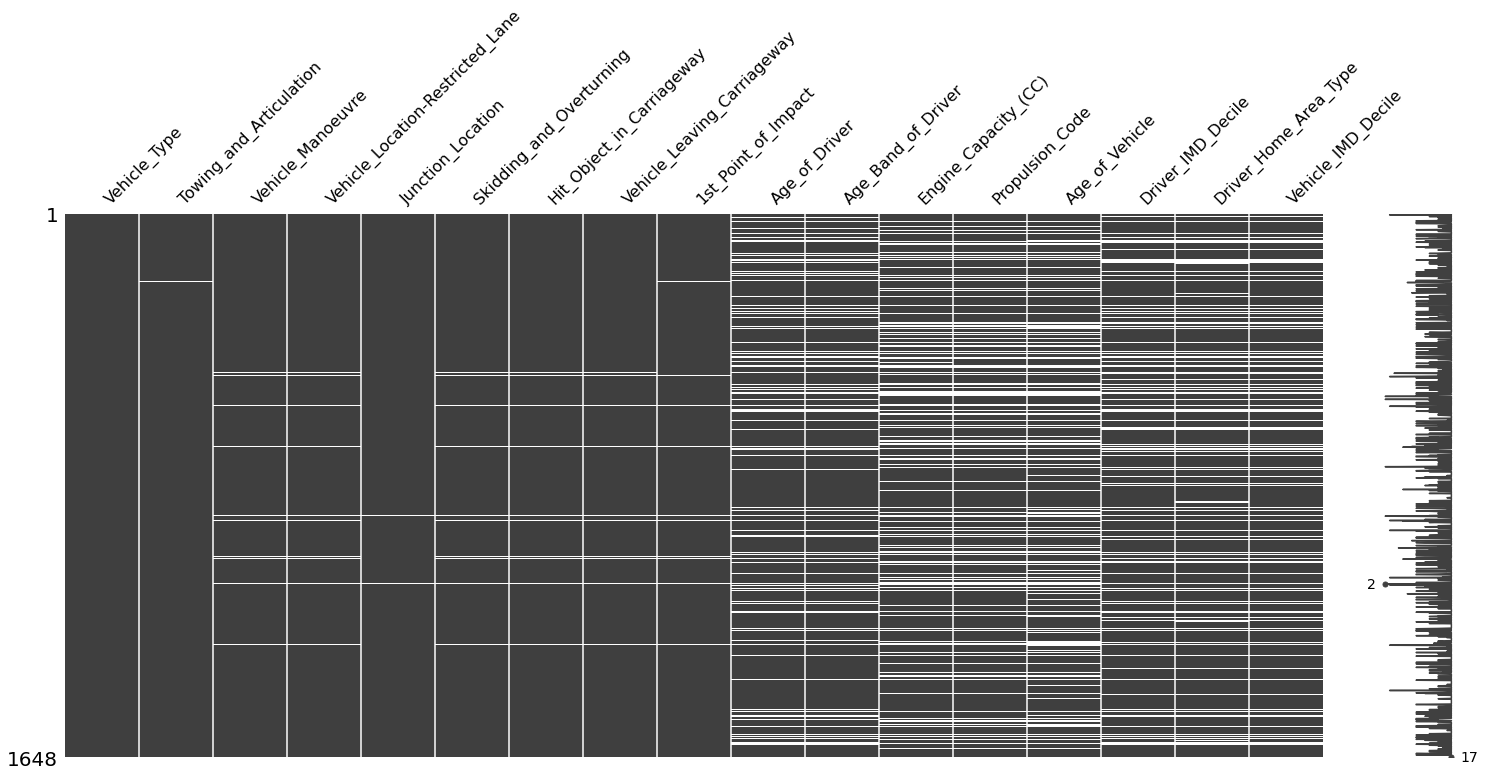

In [20]:
# ###NOT FULLY WORKING
sheffield_data['vehicles'].replace(-1, np.nan, inplace=True)
missingdata_df = sheffield_data['vehicles'].columns[sheffield_data['vehicles'].isnull().any()].tolist()
msno.matrix(sheffield_data['vehicles'][missingdata_df]);

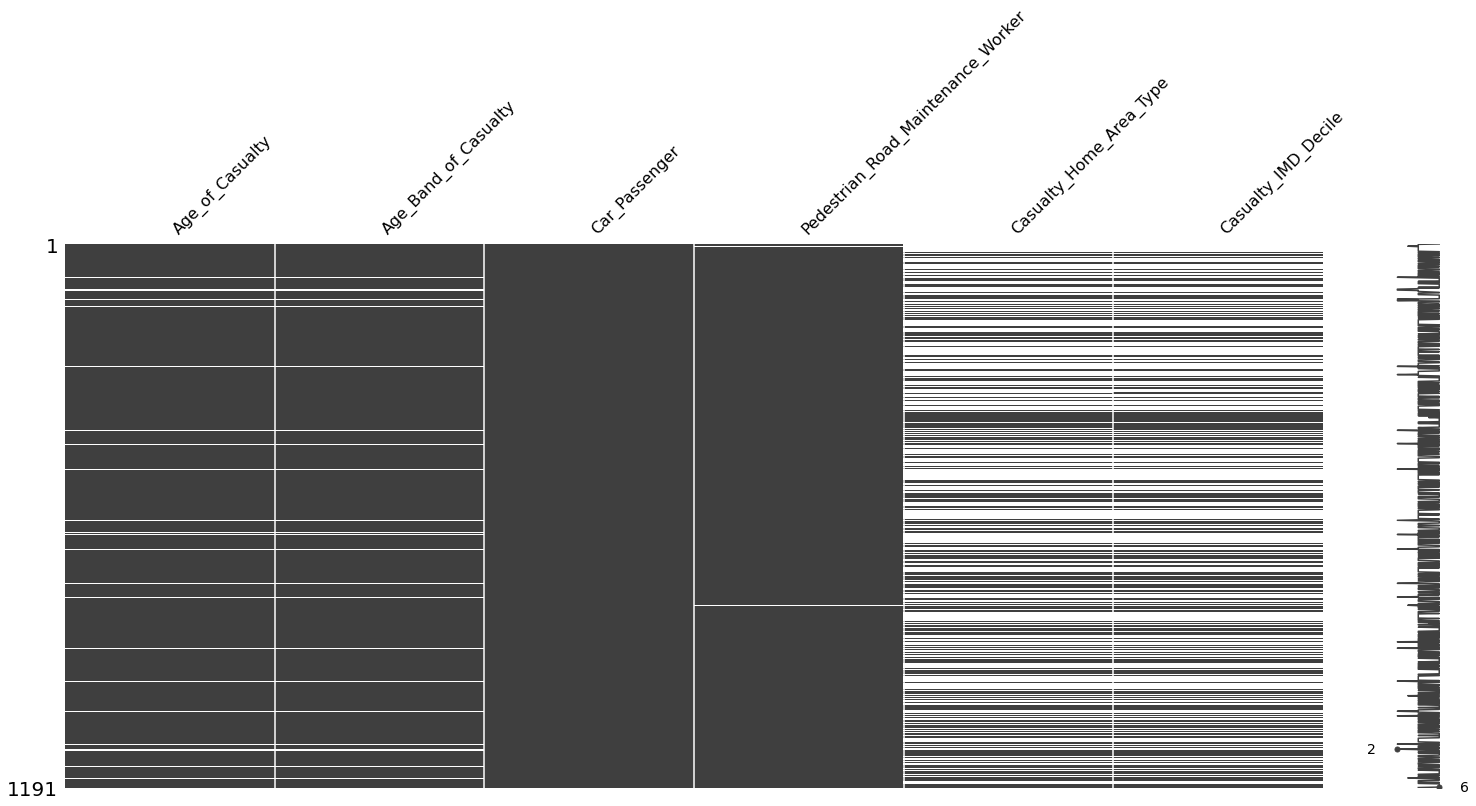

In [21]:
###NOT FULLY WORKING
sheffield_data['casualties'].replace(-1, np.nan, inplace=True)
missingdata_df = sheffield_data['casualties'].columns[sheffield_data['casualties'].isnull().any()].tolist()
msno.matrix(sheffield_data['casualties'][missingdata_df]);

## Numerical summary

In [22]:
import matplotlib.pyplot as plt

### Five Number Summary

In [23]:
print(numpy.min(x))
print(numpy.max(x))
print(numpy.std(x))
print(numpy.mean(x))
print(numpy.median(x))

NameError: name 'numpy' is not defined

### Box Plots

#### Number of vehicles in an accident and age of vehicle

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

mask_num_vehicle = (sheffield_data['accidents']['Number_of_Vehicles']>0)
NumVehicles = sheffield_data['accidents']["Number_of_Vehicles"][mask_num_vehicle]
NumVehicles = NumVehicles.to_frame()
NumVehicles.describe(), NumVehicles.boxplot(ax=ax[0]);

mask_age_vehicle = (sheffield_data['vehicles']['Age_of_Vehicle']>=0)
AgeVehicles = sheffield_data['vehicles']['Age_of_Vehicle'][mask_age_vehicle]
AgeVehicles = AgeVehicles.to_frame()
AgeVehicles.describe(), AgeVehicles.boxplot(ax=ax[1]);


#### Age of driver

In [ ]:
#AGE OF DRIVER
mask_age = (sheffield_data['vehicles']['Age_of_Driver']>=18)
Age_Driver =  sheffield_data['vehicles']["Age_of_Driver"][mask_age]
Age_Driver = Age_Driver.to_frame()
Age_Driver.describe(), Age_Driver.boxplot();

#### AGE OF MALE AND FEMALE DRIVERS 

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

mask_male = (sheffield_data['vehicles']['Sex_of_Driver']==1)
Age_MaleDrivers = sheffield_data['vehicles']["Age_of_Driver"][mask_age][mask_male]
Age_MaleDrivers = Age_MaleDrivers.to_frame()
Age_MaleDrivers.describe(), Age_MaleDrivers.boxplot(ax=ax[0])

mask_female = (sheffield_data['vehicles']['Sex_of_Driver']==2)
Age_FemaleDrivers = sheffield_data['vehicles']["Age_of_Driver"][mask_age][mask_female]
Age_FemaleDrivers = Age_FemaleDrivers.to_frame()
Age_FemaleDrivers.describe(), Age_FemaleDrivers.boxplot(ax=ax[1])
ax[0].set_ylabel("Age"), ax[1].set_ylabel("Age");

#### AGE Of CASUALTY

In [ ]:
mask_age2 = (sheffield_data['casualties']['Age_of_Casualty']>=0)
AgeCasualty = sheffield_data['casualties']["Age_of_Casualty"][mask_age2]
AgeCasualty = AgeCasualty.to_frame()

AgeCasualty.describe(), AgeCasualty.boxplot();

### Frequency Histogram

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
mask = (sheffield_data["vehicles"]["Age_of_Driver"] >=0)
sheffield_data["accidents"]["Number_of_Vehicles"].hist(ax=ax[0,0], bins=20, bottom=0.1,color = 'silver',edgecolor = 'black')
sheffield_data["accidents"]["Speed_limit"].hist(ax=ax[1,1], bins=7,color = 'silver',edgecolor = 'black');
sheffield_data["accidents"]["Number_of_Casualties"].hist(ax=ax[0,1], bins=20, bottom=0.1,color = 'silver',edgecolor = 'black')
sheffield_data["vehicles"]["Age_of_Driver"][mask].hist(ax=ax[1,0], bins=50, bottom=0.1,color = 'silver',edgecolor = 'black')

ax[0,0].set_title('Histogram over Number of Vehicles in an accident')
ax[1,1].set_title('Histogram over Speed Limit in an accident')
ax[0,1].set_title('Histogram over Number of Casualties in an accident')
ax[1,0].set_title('Histogram over Age of Driver in an accident')

ax[0,0].set_ylabel('Frequency')
ax[1,0].set_ylabel('Frequency')
ax[0,1].set_ylabel('Frequency')
ax[1,1].set_ylabel('Frequency')

ax[0,0].set_xlabel('Amount of vehicles')
ax[1,1].set_xlabel('Speed Limit')
ax[0,1].set_xlabel('Number of Casualties')
ax[1,0].set_xlabel('Age of Driver')

ax[0,0].set_yscale('log')
ax[1,1].set_yscale('log')
ax[0,1].set_yscale('log')
ax[1,0].set_yscale('log')
plt.plot();

### Frequency Barplot

In [264]:
AS_count = sheffield_data["accidents"]["Accident_Severity"].value_counts()
AS_unq = sheffield_data["accidents"]["Accident_Severity"].unique()

RT = sheffield_data["accidents"]["Road_Type"][(sheffield_data["accidents"]["Road_Type"] >0)]
RT_count = RT.value_counts()
RT_unq = [1,2,3,4,5,6]

sex = sheffield_data["vehicles"]["Sex_of_Driver"][(sheffield_data["vehicles"]["Sex_of_Driver"] >0)]
sex_counts = sex.value_counts()
sex_unq = sex.unique()

CC_counts = sheffield_data["casualties"]["Casualty_Class"].value_counts()
CC_unq = sheffield_data["casualties"]["Casualty_Class"].unique()

mask = (sheffield_data["vehicles"]["1st_Point_of_Impact"] >= 0)
PoI_counts = sheffield_data["vehicles"]["1st_Point_of_Impact"][mask].value_counts()
PoI_unq = sheffield_data["vehicles"]["1st_Point_of_Impact"][mask].unique()


6    686
3    144
1     51
9     10
7      9
2      9
Name: Road_Type, dtype: int64

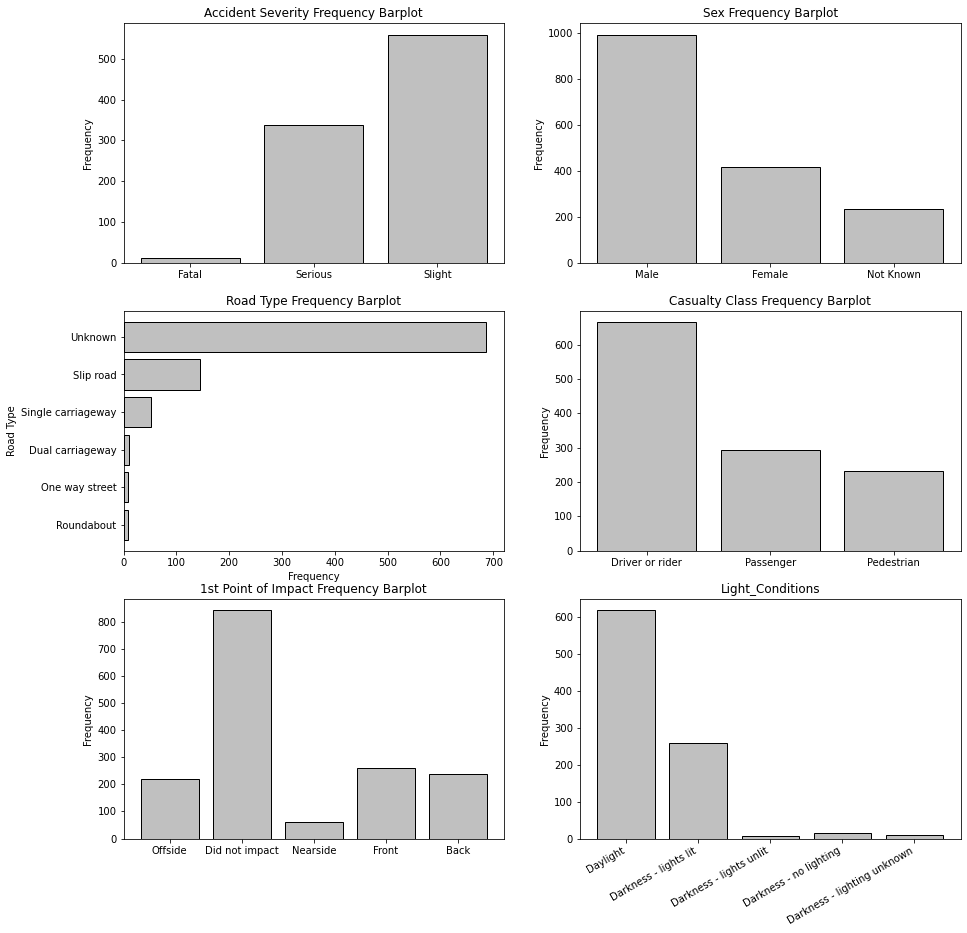

In [268]:
fig, ax = plt.subplots(3, 2, figsize=(15, 15))

ax[0,0].set_title("Accident Severity Frequency Barplot")
ax[0,0].set_ylabel("Frequency")
ax[0,0].bar(sorted(AS_unq), sorted(AS_count), tick_label = ["Fatal", "Serious", "Slight"],color = 'silver',edgecolor = 'black')

ax[1,0].set_title("Road Type Frequency Barplot")
ax[1,0].set_ylabel("Road Type")
ax[1,0].set_xlabel("Frequency")
l = ["Roundabout", "One way street", "Dual carriageway","Single carriageway", "Slip road", "Unknown"]  
ax[1,0].barh(sorted(RT_unq), sorted(RT_count), tick_label = l,color = 'silver',edgecolor = 'black')

                                                                                                                        


ax[0,1].set_title("Sex Frequency Barplot")
ax[0,1].set_ylabel("Frequency")
ax[0,1].bar(sorted(sex_unq), sex_counts, tick_label = ["Male","Female","Not Known"],color = 'silver',edgecolor = 'black')


ax[1,1].set_title("Casualty Class Frequency Barplot")
ax[1,1].set_ylabel("Frequency")
ax[1,1].bar(sorted(CC_unq), CC_counts, tick_label = ["Driver or rider", "Passenger", "Pedestrian"],color = 'silver',edgecolor = 'black')


ax[2,0].set_title("1st Point of Impact Frequency Barplot")
ax[2,0].set_ylabel("Frequency")
ax[2,0].bar(PoI_unq, PoI_counts, tick_label = ["Did not impact", "Front", "Back","Offside", "Nearside"], color = 'silver',edgecolor = 'black')


field_name = "Light_Conditions"
field_categories = {1: "Daylight", 4: "Darkness - lights lit", 5: "Darkness - lights unlit", 6: "Darkness - no lighting", 7: "Darkness - lighting unknown", -1: "Data missing or out of range"}

ax[2,1].set_title(field_name)
ax[2,1].set_ylabel("Frequency")

categories, counts = np.unique(sheffield_data["accidents"][field_name], return_counts=True)
ax[2,1].set_xticks(range(len(categories)))
ax[2,1].set_xticklabels(field_categories.values());

ax[2,1].bar(range(len(categories)), counts, color = 'silver',edgecolor = 'black')

plt.setp(ax[2,1].get_xticklabels(), rotation=30, ha='right')

plt.plot();


# Task 1

### Report the frequency of road collisions in your city for 

1. different age groups 
2. in different times (during the day, the week, or year)
3. and for differences in one other condition.


#### Different age groups

In [ ]:
mask_age = (sheffield_data["vehicles"]["Age_of_Driver"] >= 0)
AoD = sheffield_data["vehicles"]["Age_of_Driver"][mask_age]


l = []
mask = (sheffield_data["vehicles"]["Age_of_Driver"] <20)

l.append(AoD[mask].shape[0])
mask = (sheffield_data["vehicles"]["Age_of_Driver"] >20) & (sheffield_data["vehicles"]["Age_of_Driver"] <40)
l.append(AoD[mask].shape[0])
mask = (sheffield_data["vehicles"]["Age_of_Driver"] >40) & (sheffield_data["vehicles"]["Age_of_Driver"] <60)
l.append(AoD[mask].shape[0])
mask = (sheffield_data["vehicles"]["Age_of_Driver"] >60) & (sheffield_data["vehicles"]["Age_of_Driver"] <80)
l.append(AoD[mask].shape[0])
mask = (sheffield_data["vehicles"]["Age_of_Driver"] >80)
l.append(AoD[mask].shape[0])

fig = plt.figure(figsize=(15,5))
axes = fig.add_axes([0,0,1,1])
axes.set_title("Frequency of road collisions in Sheffield for different age groups")
axes.set_ylabel("Frequency")
axes.bar(["<20",'20-40', '40-60', '60-80', '80+'], l,color = 'silver',edgecolor = 'black')

for index,value in enumerate(l):
    axes.text(index - 0.015, value + 0.05,str(value),ha='center', va='bottom')

plt.plot();

#### Different times

##### Day

In [ ]:
l = [['00:00', '02:00'], 
     ['02:00', '04:00'], 
     ['04:00', '06:00'], 
     ['06:00', '08:00'], 
     ['08:00', '10:00'], 
     ['10:00', '12:00'],
     ['12:00', '14:00'], 
     ['14:00', '16:00'], 
     ['16:00', '18:00'], 
     ['18:00', '20:00'], 
     ['20:00', '22:00'],
     ['22:00', '24:00']]

empty = []
for i in range(0,12):
    mask = (sheffield_data["accidents"]["Time"] < l[i][1]) & (sheffield_data["accidents"]["Time"] > l[i][0])
    total = len(sheffield_data["accidents"][mask]["Time"])
    empty.append(total)
    
fig = plt.figure(figsize=(15,5))
axes = fig.add_axes([0,0,1,1])
axes.set_title("Frequency of road collisions in Sheffield in a 2 hour interval")
axes.set_ylabel("Frequency")
interval = ["00:00-02:00",'02:00-04:00', '04:00-06:00', '06:00-08:00', '08:00-10:00', '10:00-12:00',
                 '12:00-14:00','14:00-16:00', '16:00-18:00', '18:00-20:00', '20:00-22:00', '22:00-24:00']
axes.bar(interval, empty,color = 'silver',edgecolor = 'black');
for index,value in enumerate(empty):
    axes.text(index - 0.015, value + 0.05,str(value), ha='center', va='bottom')

##### Week

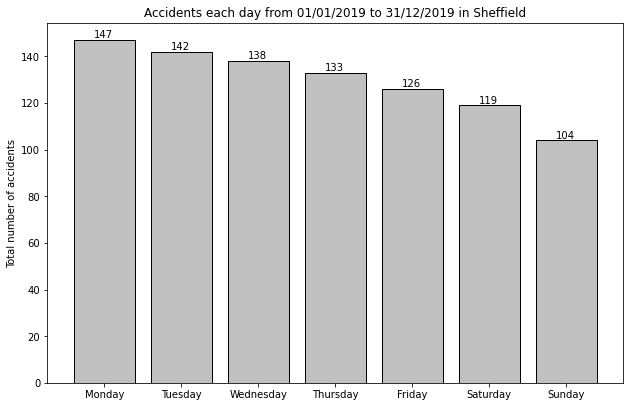

In [215]:
week = ["Monday", "Tuesday", "Wednesday","Thursday","Friday", "Saturday", "Sunday"]
unq = sheffield_data["accidents"]["Day_of_Week"].unique()
count = sheffield_data["accidents"]["Day_of_Week"].value_counts()
fig = plt.figure(figsize=(8, 5))
axes = fig.add_axes([0, 0, 1, 1])
axes.set_title("Accidents each day from 01/01/2019 to 31/12/2019 in Sheffield")
axes.set_ylabel("Total number of accidents")
axes.bar(sorted(unq), count, tick_label = week,color = 'silver',edgecolor = 'black')

for index,value in enumerate(count):
    axes.text(index + 1 - 0.015, value + 0.05,str(value),ha='center', va='bottom')
    

plt.plot();

##### Year

In [ ]:
list_month = [
'January',
'February',
'March',
'April',
'May',
'June',
'July',
'August',
'September',
'October',
'November',
'December'
]
accident_severity = sheffield_data['accidents']['Accident_Severity']
accident_dates = pd.to_datetime(sheffield_data['accidents']['Date'])
a = accident_severity.groupby(accident_dates.dt.month).sum()
fig,ax = plt.subplots(figsize = (16,4))
a.plot.bar(color = 'silver',edgecolor = 'black',rot = 0)
ax.set_title('Monthly Accident Numbers')
ax.set_xlabel('Months')
ax.set_ylabel('Number of Accidents')
ax.set_xticklabels(list_month)
for index,value in enumerate(a):
    ax.text(index - 0.015, value + 0.05,str(value),ha='center', va='bottom')

##### Number of accidents each day

In [ ]:
#COUNTING THE ACCIDENTS EACH DAY IN EVERY MONTH

accident_severity = sheffield_data['accidents']['Accident_Severity']

accident_dates = pd.to_datetime(sheffield_data['accidents']['Date'])

accident_dates1 = accident_dates.dt.date



mask = (accident_dates > "2019-12-01") & (accident_dates <= "2019-12-31")
s = accident_dates1[mask].value_counts()
s1 = pd.DataFrame(s)
s1.columns = ['Accidents']
print(s1.to_markdown(tablefmt = 'github'))

##### Monthly Accident Severity

In [ ]:
#####MONTHLY SEVERITY 2
accident_severity = sheffield_data['accidents']['Accident_Severity']
accident_dates = pd.to_datetime(sheffield_data['accidents']['Date'])
#accident_severity.groupby(accident_dates.dt.month).count().plot(kind="bar")
a = accident_severity.groupby(accident_dates.dt.month)
a1 = a.value_counts()

fig,ax = plt.subplots(figsize = (16,4))
a1.plot.bar(color = 'silver',edgecolor = 'black',rot = 45)
ax.set_title('Monthly Accident Severity')
ax.set_xlabel('(Month,Accident_Severity)')
ax.set_ylabel('Number of Accidents')
ax.legend(loc = "upper left")
for index,value in enumerate(a1):
    ax.text(index - 0.015, value + 0.05,str(value),ha='center', va='bottom')

# Task 2 - Associations

## Research whether there is a significant statistical association in your city, either
1. between some vehicle attributes and accident circumstances, or 
2. between some casualty attributes and accident circumstances. 

Report whether there is a statistically significant association between such variables or not, together with the appropriate statistical metric(s).
 
Discuss why this association, or the lack of
this association, is relevant for urban/transport planning.

### Speed limit and Accident Severity

In [ ]:
mask = (sheffield_data["accidents"]["Speed_limit"] != -1)
severityspeed = np.array([sheffield_data["accidents"]["Speed_limit"][mask], sheffield_data["accidents"]["Accident_Severity"][mask]]).T
observed_pd = pd.crosstab(severityspeed[:, 0], severityspeed[:, 1], rownames = ["Speed limit"], colnames = ["Accident Severity"]) 
observed_pd_n = pd.crosstab(severityspeed[:, 0], severityspeed[:, 1], rownames = ["Speed limit"], colnames = ["Accident Severity"], normalize = True) 
observed = observed_pd.to_numpy()

chiVal, pVal, df, expected = chi2_contingency(observed)

alpha = 0.05
print("p value is " + str(pVal)) 
if pVal <= alpha: 
    print('Dependent (reject H0)') 
else: 
    print('Independent (H0 holds true)')
    
N = observed.sum(axis = 1).sum()
    
V = np.sqrt( (chiVal/N) / (min(observed.shape)-1) )
print("V: "+ str(V) + " a value close to 0 means weak, close to 1 means strong")
#observed_pd

Since pVal > 0.1 the association between speed limit and accident severity in Sheffield is not significant. 

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 6))

severity_labels = ["Fatal", "Serious", "Slight"]
speed_categories = {20: "20 MPH", 30: "30 MPH", 40: "40 MPH", 50: "50 MPH", 60: "60 MPH", 70: "70 MPH"}
x = np.array(list(speed_categories.keys()))

for i, ax in enumerate(axes[0]):
    ax.plot(x, observed[:,i], 'ro-', label='Observed')
    ax.plot(x, expected[:,i], 'bo-', label='Expected')
    if i==0: 
        ax.set_ylabel('Casualties')
        ax.legend(loc='best');
    ax.set_title(severity_labels[i])
    ax.set_xticks(x)
    ax.set_xticklabels(list(speed_categories.values()))
    fig.autofmt_xdate(rotation=45)

for i, ax in enumerate(axes[1]):
    ax.plot(x, observed[:,i]/expected[:,i], 'go-')
    ax.plot(x, np.ones(x.shape), 'k:')
    
    if i==0: 
        ax.set_ylabel('Observed/Expected')
    ax.set_xticks(x)
    ax.set_xticklabels(list(speed_categories.values()))
    fig.autofmt_xdate(rotation=45)

### Accident severity and road type

In [213]:
mask = (sheffield_data["accidents"]["Road_Type"] != -1)
severityRoad = np.array([sheffield_data["accidents"]["Road_Type"][mask], sheffield_data["accidents"]["Accident_Severity"][mask]]).T
observed_pd = pd.crosstab(severityRoad[:, 0], severityRoad[:, 1], rownames = ["Road Type"], colnames = ["Accident Severity"]) 
observed_pd_n = pd.crosstab(severityRoad[:, 0], severityRoad[:, 1], rownames = ["Road Type"], colnames = ["Accident Severity"], normalize = True) 
observed = observed_pd.to_numpy()

chiVal, pVal, df, expected = chi2_contingency(observed)

alpha = 0.05
print("p value is " + str(pVal)) 
if pVal <= alpha: 
    print('Dependent (reject H0)') 
else: 
    print('Independent (H0 holds true)')
    
N = observed.sum(axis = 1).sum()    

V = np.sqrt( (chiVal/N) / (min(observed.shape)-1) )
print("V: "+ str(V) + " a value close to 0 means weak, close to 1 means strong")
#observed_pd

p value is 0.5710736711026121
Independent (H0 holds true)
V: 0.06875213481103486 a value close to 0 means weak, close to 1 means strong


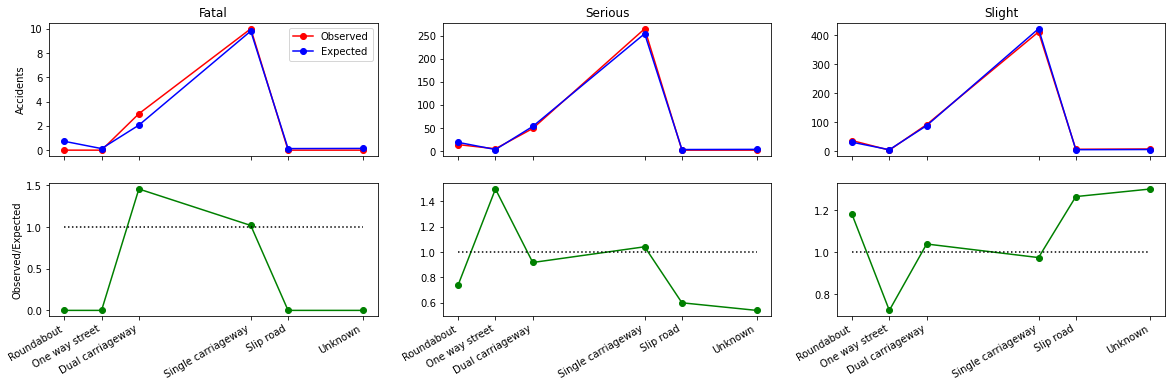

In [214]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 6))

severity_labels = ["Fatal", "Serious", "Slight"]
road_categories = {1: "Roundabout", 2: "One way street", 3: "Dual carriageway", 6: "Single carriageway", 7: "Slip road", 9: "Unknown"}
x = np.array(list(road_categories.keys()))

for i, ax in enumerate(axes[0]):
    ax.plot(x, observed[:,i], 'ro-', label='Observed')
    ax.plot(x, expected[:,i], 'bo-', label='Expected')
    if i==0: 
        ax.set_ylabel('Accidents')
        ax.legend(loc='best');
    ax.set_title(severity_labels[i])
    ax.set_xticks(x)
    ax.set_xticklabels(list(road_categories.values()))
    fig.autofmt_xdate(rotation=45)

for i, ax in enumerate(axes[1]):
    ax.plot(x, observed[:,i]/expected[:,i], 'go-')
    ax.plot(x, np.ones(x.shape), 'k:')
    
    if i==0: 
        ax.set_ylabel('Observed/Expected')
    ax.set_xticks(x)
    ax.set_xticklabels(list(road_categories.values()))
    fig.autofmt_xdate(rotation=30)

### Road Type and Light Conditions

In [ ]:
mask = (sheffield_data["accidents"]["Road_Type"] != -1
       ) & (sheffield_data["accidents"]["Light_Conditions"] != -1
       ) & (sheffield_data["accidents"]["Light_Conditions"] != 7)
lightRoad = np.array([sheffield_data["accidents"]["Road_Type"][mask], 
                      sheffield_data["accidents"]["Light_Conditions"][mask]]).T

observed_pd = pd.crosstab(lightRoad[:, 0], lightRoad[:, 1], 
                          rownames = ["Road Type"], colnames = ["Light Conditions"]) 

observed_pd_n = pd.crosstab(lightRoad[:, 0], lightRoad[:, 1], 
                            rownames = ["Road Type"], colnames = ["Light Conditions"], normalize = True) 

observed = observed_pd.to_numpy()

chiVal, pVal, df, expected = chi2_contingency(observed)

alpha = 0.05
print("p value is " + str(pVal)) 
if pVal <= alpha: 
    print('Dependent (reject H0)') 
else: 
    print('Independent (H0 holds true)')
    
N = observed.sum(axis = 1).sum()    

V = np.sqrt( (chiVal/N) / (min(observed.shape)-1) )
print("V: "+ str(V) + " a value close to 0 means weak, close to 1 means strong")
observed_pd

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 6))

light_labels = ["Daylight", "Darkness - lights lit", "Darkness - lights unlit", "Darkness - no lighting", "Darkness - lighting unknown"]
road_categories = {1: "Roundabout", 2: "One way street", 3: "Dual carriageway", 6: "Single carriageway", 7: "Slip road", 9: "Unknown"}
x = np.array(list(road_categories.keys()))

for i, ax in enumerate(axes[0]):
    ax.plot(x, observed[:,i], 'ro-', label='Observed')
    ax.plot(x, expected[:,i], 'bo-', label='Expected')
    if i==0: 
        ax.set_ylabel('Accidents')
        ax.legend(loc='best');
    ax.set_title(light_labels[i])
    ax.set_xticks(x)
    ax.set_xticklabels(list(road_categories.values()))
    fig.autofmt_xdate(rotation=45)

for i, ax in enumerate(axes[1]):
    ax.plot(x, observed[:,i]/expected[:,i], 'go-')
    ax.plot(x, np.ones(x.shape), 'k:')
    
    if i==0: 
        ax.set_ylabel('Observed/Expected')
    ax.set_xticks(x)
    ax.set_xticklabels(list(road_categories.values()))
    fig.autofmt_xdate(rotation=30)
    


# Task 3 - Map visualization


Visualize the reported collisions on a map of your city. Make a visual distinction between different
classes of casualty severity

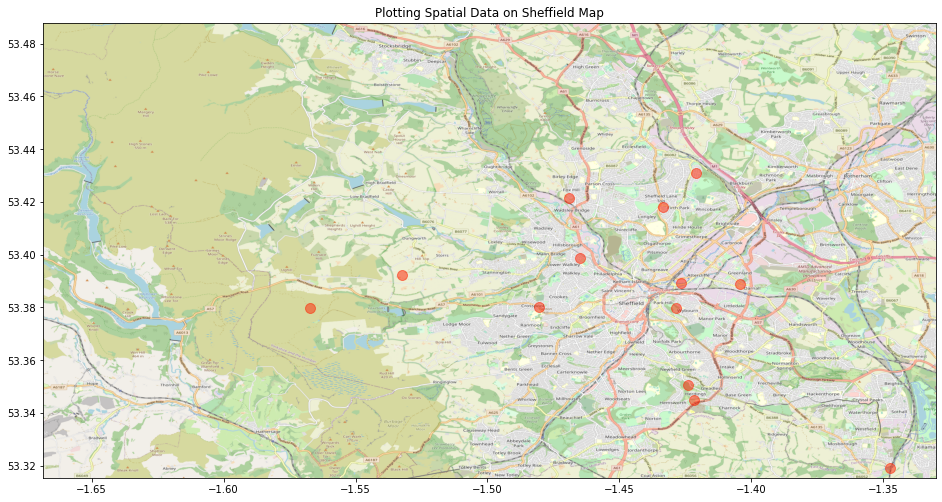

In [299]:
BBox = min(sheffield_data["accidents"]["Longitude"]), max(sheffield_data["accidents"]["Longitude"]), min(sheffield_data["accidents"]["Latitude"]),  max(sheffield_data["accidents"]["Latitude"])
ruh_m = plt.imread('../map.png')
mask_1 = (sheffield_data["accidents"]["Accident_Severity"] == 1)
#mask_2 = (sheffield_data["accidents"]["Accident_Severity"] == 2)
#mask_3 = (sheffield_data["accidents"]["Accident_Severity"] == 3)
fig, ax = plt.subplots(figsize = (16,14))

ax.scatter(sheffield_data["accidents"]["Longitude"][mask_1], sheffield_data["accidents"]["Latitude"][mask_1], alpha= 0.5, c='#FF2100', s=100)
#ax.scatter(sheffield_data["accidents"]["Longitude"][mask_2], sheffield_data["accidents"]["Latitude"][mask_2], alpha= 0.5, c='#FFF600', s=90)
#ax.scatter(sheffield_data["accidents"]["Longitude"][mask_3], sheffield_data["accidents"]["Latitude"][mask_3], alpha= 0.5, c='g', s=80)

ax.set_title('Plotting Spatial Data on Sheffield Map')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
ax.imshow(ruh_m, zorder=0, extent = BBox, aspect= 'equal');

In [187]:
mask_1 = (sheffield_data["accidents"]["Accident_Severity"] == 1)
sheffield_data["accidents"][mask_1]

,Accident_Index,Location_Easting_OSGR,Location_Northing_OSGR,Longitude,Latitude,Police_Force,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,Date,...,Pedestrian_Crossing-Human_Control,Pedestrian_Crossing-Physical_Facilities,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Special_Conditions_at_Site,Carriageway_Hazards,Urban_or_Rural_Area,Did_Police_Officer_Attend_Scene_of_Accident,LSOA_of_Accident_Location
44676,2019140805414,435393.0,391745.0,-1.468895,53.421340,14,1,1,1,01/01/2019,...,0.0,1.0,4,1,1,0,0,1,1,E01008123
44756,2019140808795,435665.0,389241.0,-1.465084,53.398816,14,1,1,1,14/01/2019,...,0.0,8.0,1,1,2,0,0,1,1,E01007870
44799,2019140810574,438444.0,383920.0,-1.423937,53.350796,14,1,1,1,24/01/2019,...,0.0,8.0,1,1,2,0,0,1,1,E01008001
45416,2019140836455,439708.0,388157.0,-1.404420,53.388785,14,1,1,1,03/05/2019,...,0.0,0.0,1,2,2,0,0,1,1,E01007902
45529,2019140841713,434668.0,387144.0,-1.480307,53.380034,14,1,1,1,22/05/2019,...,0.0,0.0,4,1,1,0,0,1,1,E01033266
45630,2019140846089,438581.0,392821.0,-1.420796,53.430789,14,1,3,2,07/06/2019,...,0.0,0.0,1,1,1,0,0,1,1,E01007852
45637,2019140846175,431194.0,388485.0,-1.532398,53.392302,14,1,1,1,08/06/2019,...,0.0,0.0,4,1,1,0,0,1,1,E01008133
45818,2019140854757,428889.0,387088.0,-1.567184,53.379876,14,1,2,1,05/07/2019,...,0.0,0.0,1,1,1,0,0,2,1,E01008158
45924,2019140860357,438591.0,383285.0,-1.421806,53.345078,14,1,1,1,22/07/2019,...,0.0,0.0,1,1,1,0,0,1,1,E01007846
46003,2019140865140,437748.0,391395.0,-1.433502,53.418032,14,1,3,2,31/07/2019,...,0.0,0.0,1,1,1,0,0,1,1,E01007850


# Task 4: Open question

Use the data to formulate, motivate, answer, and discuss another research question of your choice.
For example, compare your city to the whole UK, or investigate different collision participants (bicycle
vs car, bicycle-motored two-wheeler, pedestrian vs car, car vs car,…), or compare the age distribution
of casualties to the existing age distribution, or rank/compare how problematic different driver
demographics are (young/old male/female),…

Open question: At what road type is the highest amount of fatal and severe accidents and what can be done to reduce these? 

To further pursue this the categorical violin scatter plot of 3 variables, road type, number of vehicles and accident severity is plotted. Thus we can see that the accidents with the most vehicles occour in Single Carriageway. Now it is also clear that a fair amount of slight accident severity occour even when there is a lot of vehicles.

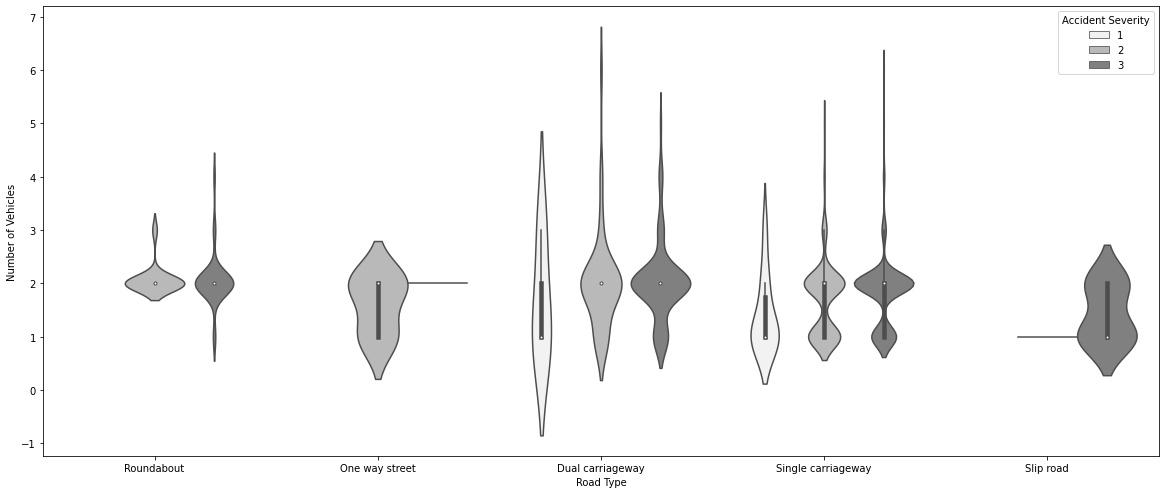

In [229]:
mask = (sheffield_data["accidents"]["Road_Type"] != 9
       ) & (sheffield_data["accidents"]["Road_Type"] != -1
       ) & (sheffield_data["accidents"]["Number_of_Vehicles"]!=-1)
data_toplot = np.array([sheffield_data["accidents"]["Road_Type"][mask], 
                        sheffield_data["accidents"]["Number_of_Vehicles"][mask],
                        sheffield_data["accidents"]["Accident_Severity"][mask]]).T


data = (pd.DataFrame(data_toplot, columns=['Road Type', 'Number of Vehicles', 'Accident Severity'])).sort_values(by=['Accident Severity'], ascending = True)

fig, ax = plt.subplots(figsize=(20, 8.27))

sns.violinplot(ax = ax, x='Road Type', y='Number of Vehicles', hue='Accident Severity', data=data, color='grey') 

ax.set_xticklabels(["Roundabout", "One way street", "Dual carriageway", "Single carriageway", "Slip road", "One way street/Slip road"]);

for index,value in enumerate(count):
    axes.text(index + 1 - 0.015, value + 0.05,str(value),ha='center', va='bottom')

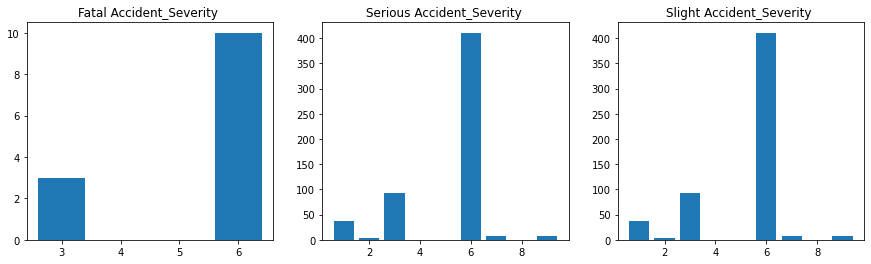

In [308]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4))

ac3 = sheffield_data["accidents"]["Road_Type"][(sheffield_data["accidents"]["Accident_Severity"] == 3)]
ac3_counts = ac3.value_counts()
ac3_unq = ac3.unique()
ax[2].bar(sorted(ac3_unq), ac3_counts.sort_index());
ax[2].set_title("Slight Accident_Severity ")


ac2 = sheffield_data["accidents"]["Road_Type"][(sheffield_data["accidents"]["Accident_Severity"] == 2)]
ac2_counts = ac3.value_counts()
ac2_unq = ac3.unique()
ax[1].bar(sorted(ac2_unq), ac3_counts.sort_index());
ax[1].set_title("Serious Accident_Severity ")


ac1 = sheffield_data["accidents"][(sheffield_data["accidents"]["Accident_Severity"] == 1)]
ac1_counts = ac1["Road_Type"].value_counts()
ac1_unq = ac1["Road_Type"].unique()
ax[0].bar(sorted(ac1_unq), ac1_counts.sort_index());
ax[0].set_title("Fatal Accident_Severity ");

Now the fatal accidents on Single carriageway is to be analysed

From the previous map visualization, it shows that none of these fatal accidents occured in the same place. Thus one can conclude that it is the result of one location and there must be a common occurence in these accidents. 

In [318]:
print(ac1["Number_of_Vehicles"].value_counts())

1    9
3    2
2    2
Name: Number_of_Vehicles, dtype: int64


Majority of these accidents occured by only one vehicle being part of the accident ...

In [319]:
print(ac1["Number_of_Casualties"].value_counts())

1    11
2     2
Name: Number_of_Casualties, dtype: int64


... and majority of the accidents involved one casualty

In [321]:
print(ac1["Light_Conditions"].value_counts())

1    8
4    5
Name: Light_Conditions, dtype: int64


8 of the 13 accidents occured in full daylight and the rest occured in Darkness, though the lights were lit. Thus one can conclude that the accidents were not caused by lack of lighting. Though it is unclear whether the lighting is adequate for the road type. This would be tested by travelling to the location of the accident and inspecting the lighting conditions  

In [328]:
print(ac1["Time"].sort_values())

46352    02:30
44676    04:09
45416    07:16
45630    08:08
44799    09:03
46003    09:55
44756    10:37
45924    14:20
45818    14:40
46213    17:41
46450    19:25
45529    22:19
45637    23:44
Name: Time, dtype: object


4 accidents occured in the late evening, night or early morning, the rest of the accidents occured from 07.00 to 19.30. It could be thought that the cause for these four accidents could be the time of the day and that they perhabs had gotten drowsy during the day.

In [330]:
print(ac1["Junction_Detail"].value_counts())

3    8
0    3
9    1
6    1
Name: Junction_Detail, dtype: int64


Majority of these accidents occured in/at a T or staggered junction. Thus this could be the cause of poor speed regulation, bad view of other cars, pedestrians and/or cyclist. 

In [331]:
print(ac1["Junction_Control"].value_counts())

4.0    9
2.0    1
Name: Junction_Control, dtype: int64


Almost all of these accidents occured at a "Give way or uncontrolled" junction control. Which could imply that there could be room for improve on this factor

In [348]:
common = ac1.merge(sheffield_data["casualties"],on=['Accident_Index','Accident_Index'])

In [349]:
common["Casualty_Class"].value_counts()

3    8
1    7
Name: Casualty_Class, dtype: int64

Half of the people that were in the accidents were "pedestrians" where as the other half was "driver or rider" ...

In [350]:
common["Casualty_Severity"].value_counts()

1    14
3     1
Name: Casualty_Severity, dtype: int64

... of which 14 died and one had slight injuries

In [353]:
common["Pedestrian_Location"].value_counts()

0     7
9     5
10    1
5     1
4     1
Name: Pedestrian_Location, dtype: int64

5 subjects were in carriageway and crossing elsewhere.

In [354]:
full = common.merge(sheffield_data["vehicles"],on=['Accident_Index','Accident_Index'])

In [359]:
full["Vehicle_Manoeuvre"].value_counts()

18.0    11
2.0      8
7.0      2
4.0      1
10.0     1
9.0      1
6.0      1
Name: Vehicle_Manoeuvre, dtype: int64

11 vehicles in the manoeuvre leading up to the accident was "Going ahead other" and 8 vehicles were parked. One can think that the parked vehicles did not play a part in the accidents. Also since there were more cars involved in the accident than casulaties, must one conclude that the vehicles "Going ahead other" drove into the parked cars

In [360]:
full["Junction_Location"].value_counts()

0.0    13
1.0     4
2.0     3
6.0     2
8.0     2
5.0     1
Name: Junction_Location, dtype: int64

Majority of the vehicles in the accidents were "Not at or within 20 metres of junction", majority of the remaining cars where parked

In [363]:
full["Sex_of_Driver"].value_counts()

1    15
3     8
2     2
Name: Sex_of_Driver, dtype: int64

Majority of the sex of the driver was male, in fact 15 of the vehicles that occured in the accident was male. 8 was unknown, which probably was the owners of the parked cars

In [364]:
full["Age_of_Driver"].value_counts()

39.0    4
54.0    2
56.0    1
25.0    1
38.0    1
20.0    1
70.0    1
66.0    1
22.0    1
51.0    1
34.0    1
49.0    1
21.0    1
Name: Age_of_Driver, dtype: int64

The age range that had the most fatal accidents in Sheffield was the age range from 35 to 60. Which would contradict popular belief that young people are the main cause of trafic accidents.

In [365]:
full["Skidding_and_Overturning"].value_counts()

0.0    21
1.0     4
Name: Skidding_and_Overturning, dtype: int64

Four of the vehicles in the accidents skidded, which could imply poor judgement of conditions

In [369]:
ac1["Special_Conditions_at_Site"].value_counts()

0    13
Name: Special_Conditions_at_Site, dtype: int64

### Conclusion

Our suggestion to reduce the frequency of fatal accidents, would be to set up proper/improve signage so that vehicles either can physically not drive faster or perhabs add chicanes. Since majority of the fatal casualties were pedestrians that did not cross at a pedestrian crossing, adding more pedestrian crossing or improving pedestrian conditions could reduce accidents of pedestrians crossing a road not at a pedestrian crossing. Also a Single Carriageway is a road that is not meant for pedestrian crossing.

# Exercise 3

In [179]:
import seaborn as sns

- Check that all Number_of_Vehicles and Number_of_Casualties values in the accidents table are correct, by counting all the corresponding records in the vehicles and casualties tables.

In [180]:
print(sheffield_data["accidents"]["Number_of_Vehicles"].shape)
print(sheffield_data["accidents"]["Number_of_Casualties"].shape)

(909,)
(909,)


- Try out categorical scatterplots to explore combinations of numerical and categorical variables (and possible a third categorical variable for hue), where this makes sense.

Road_Type and Accident Severity, hue = sex

''

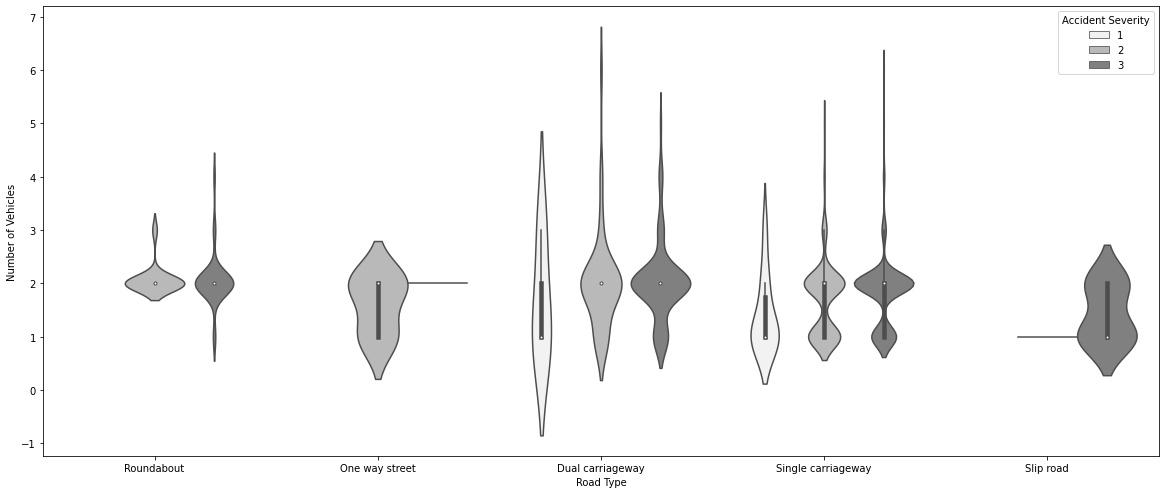

In [181]:
mask = (sheffield_data["accidents"]["Road_Type"] != 9
       ) & (sheffield_data["accidents"]["Road_Type"] != -1
       ) & (sheffield_data["accidents"]["Number_of_Vehicles"]!=-1
       )
data_toplot = np.array([sheffield_data["accidents"]["Road_Type"][mask], 
                        sheffield_data["accidents"]["Number_of_Vehicles"][mask],
                        sheffield_data["accidents"]["Accident_Severity"][mask]]).T


data = (pd.DataFrame(data_toplot, columns=['Road Type', 'Number of Vehicles', 'Accident Severity'])).sort_values(by=['Accident Severity'], ascending = True)

fig, ax = plt.subplots(figsize=(20, 8.27))

sns.violinplot(ax = ax, x='Road Type', y='Number of Vehicles', hue='Accident Severity', data=data, color='grey') 

ax.set_xticklabels(["Roundabout", "One way street", "Dual carriageway", "Single carriageway", "Slip road", "One way street/Slip road"])


;

''

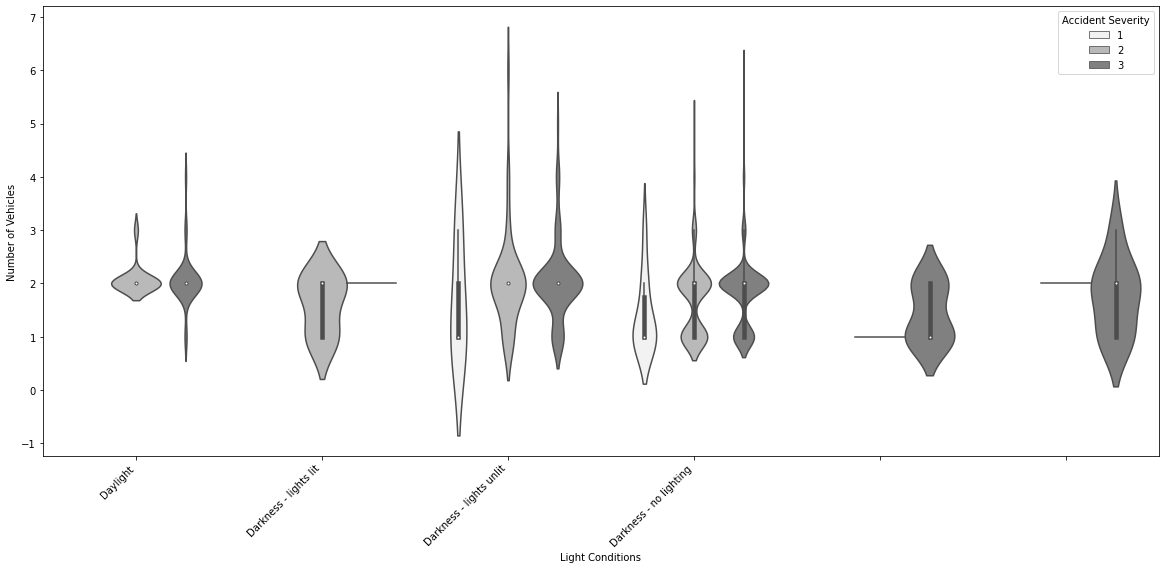

In [182]:
mask = (sheffield_data["accidents"]["Light_Conditions"] != -1
       ) & (sheffield_data["accidents"]["Number_of_Vehicles"]!=-1
       ) & (sheffield_data["accidents"]["Light_Conditions"] != 7
       )
data_toplot = np.array([sheffield_data["accidents"]["Road_Type"][mask], 
                        sheffield_data["accidents"]["Number_of_Vehicles"][mask],
                        sheffield_data["accidents"]["Accident_Severity"][mask]]).T


data = (pd.DataFrame(data_toplot, columns=['Light Conditions', 'Number of Vehicles', 'Accident Severity'])).sort_values(by=['Accident Severity'], ascending = True)

fig, ax = plt.subplots(figsize=(20, 8.27))

sns.violinplot(ax = ax, x='Light Conditions', y='Number of Vehicles', hue='Accident Severity', data=data, color='grey') 

ax.set_xticklabels(["Daylight", 
                    "Darkness - lights lit", 
                    "Darkness - lights unlit", 
                    "Darkness - no lighting"], rotation=45, ha="right")
;

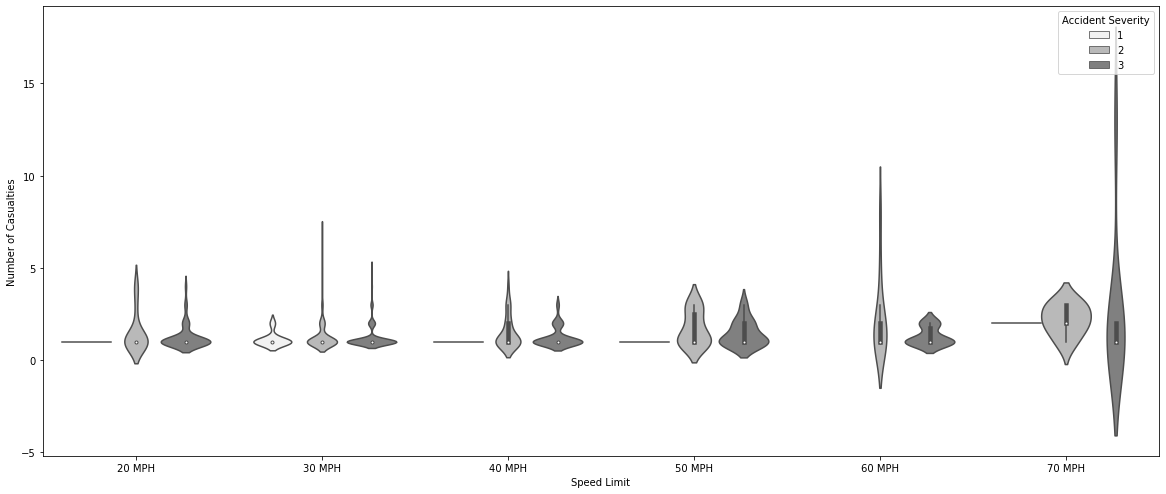

In [183]:
mask = (sheffield_data["accidents"]["Speed_limit"] != -1
       ) & (sheffield_data["accidents"]["Number_of_Casualties"] != -1)

data_toplot = np.array([sheffield_data["accidents"]["Speed_limit"][mask], 
                        sheffield_data["accidents"]["Number_of_Casualties"][mask],
                        sheffield_data["accidents"]["Accident_Severity"][mask]]).T


data = (pd.DataFrame(data_toplot, columns=['Speed Limit', 'Number of Casualties', 'Accident Severity'])).sort_values(by=['Accident Severity'], ascending = True)

fig, ax = plt.subplots(figsize=(20, 8.27))

sns.violinplot(ax = ax, x='Speed Limit', y='Number of Casualties', hue='Accident Severity', data=data, color='grey') 

ax.set_xticklabels(["20 MPH", "30 MPH","40 MPH","50 MPH","60 MPH","70 MPH"]);

<img src="../speedlimits_UK.png"/>

In [ ]:
mask = (sheffield_data["accidents"]["Speed_limit"] != -1
       ) & (sheffield_data["accidents"]["Number_of_Casualties"] != -1
       ) & (sheffield_data["accidents"]["Road_Type"] != 1
    ) & (sheffield_data["accidents"]["Road_Type"] != 9)

data_toplot = np.array([sheffield_data["accidents"]["Speed_limit"][mask], 
                        sheffield_data["accidents"]["Number_of_Casualties"][mask],
                        sheffield_data["accidents"]["Road_Type"][mask]]).T


data = (pd.DataFrame(data_toplot, columns=['Speed Limit', 'Number of Casualties', 'Road Type']))

fig, ax = plt.subplots(figsize=(20, 8.27))

sns.violinplot(ax = ax, x='Speed Limit', y='Number of Casualties', hue='Road Type', data=data, color='grey') 

ax.set_xticklabels(["20 MPH", "30 MPH","40 MPH","50 MPH","60 MPH","70 MPH"]);

# Spatial filtering with shapely

In [ ]:
import json 
import shapely
from shapely.geometry import Point, MultiPoint, LineString, MultiLineString, Polygon, MultiPolygon

In [ ]:
cityname = "Sheffield"
with open("../data/processed/" + "citieslad.json") as f:
    cities_json = json.load(f)

Jupyter visualizes shapely objects!Jupyter visualizes shapely objects!

In [ ]:
#cities_json[cityname]["geometry"]

Let's get all accident coordinates (from the whole UK)

In [ ]:
city_boundary = shapely.geometry.shape(cities_json[cityname]["geometry"])
type(city_boundary)

`contains()` and `within()` check for point inclusion:

In [ ]:
city_boundary

# random

In [132]:
PATH = {}
PATH["data_raw"] = "../data/raw/"
PATH["data_interim"] = "../data/interim/"
PATH["data_processed"] = "../data/processed/"
PATH["data_external"] = "../data/external/"

FILENAME = {}
FILENAME["accidents"] = "Road Safety Data - Accidents 2019.csv"
FILENAME["casualties"] = "Road Safety Data - Casualties 2019.csv"
FILENAME["vehicles"] = "Road Safety Data- Vehicles 2019.csv" # Note the inconsistent naming of the raw data files

TABLENAMES = ["accidents", "casualties", "vehicles"]

In [142]:
raw_data_np = {}
raw_data_np["accidents"] = np.genfromtxt("../data/raw/"+"Road Safety Data - Accidents 2019.csv", delimiter=',', dtype=None, names=True, encoding='utf-8-sig')
raw_data_np["vehicles"] = np.genfromtxt("../data/raw/"+"Road Safety Data- Vehicles 2019.csv", delimiter=',', dtype=None, names=True, encoding='utf-8-sig')
raw_data_np["casualties"] = np.genfromtxt("../data/raw/"+"Road Safety Data - Casualties 2019.csv", delimiter=',', dtype=None, names=True, encoding='utf-8-sig')

In [164]:
# 1
sheffield_index = [x["Accident_Index"] for x in dataraw["accidents"] if x["Local_Authority_District"] == 215]
# 2
sheffield_casualties = dataraw["casualties"][np.isin(dataraw["casualties"]["Accident_Index"], sheffield_index)]
# 3
#datafiltered = datafiltered[(datafiltered["Age_of_Casualty"] >= 0) & (datafiltered["Age_of_Casualty"] <= 4)]

sheffield_casualties.dtype

dtype([('Accident_Index', '<U13'), ('Vehicle_Reference', '<i4'), ('Casualty_Reference', '<i4'), ('Casualty_Class', '<i4'), ('Sex_of_Casualty', '<i4'), ('Age_of_Casualty', '<i4'), ('Age_Band_of_Casualty', '<i4'), ('Casualty_Severity', '<i4'), ('Pedestrian_Location', '<i4'), ('Pedestrian_Movement', '<i4'), ('Car_Passenger', '<i4'), ('Bus_or_Coach_Passenger', '<i4'), ('Pedestrian_Road_Maintenance_Worker', '<i4'), ('Casualty_Type', '<i4'), ('Casualty_Home_Area_Type', '<i4'), ('Casualty_IMD_Decile', '<i4')])

# Road Type Casualty Severity

In [82]:
sheffield_mask = (dataraw_np['accidents'][12] == 215)
sheffield_data_np = {}
sheffield_data_np['accidents'] = dataraw_np['accidents'][sheffield_mask]                

<ipython-input-82-cf187c1c221f>:1: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  sheffield_mask = (dataraw_np['accidents'][12] == 215)


In [177]:
mask = (sheffield_data["accidents"]["Road_Type"] != -1)
CSRoad = np.array([sheffield_data["accidents"]["Road_Type"][mask], 
                      sheffield_casualties]).T

observed_pd = pd.crosstab(CSRoad[:, 0], CSRoad[1][:, "Casualty_Severity"], 
                          rownames = ["Road Type"], colnames = ["Casualty Severity"]) 

observed_pd_n = pd.crosstab(CSRoad[:, 0], CSRoad[:, 1], 
                            rownames = ["Road Type"], colnames = ["Casualty Severity"], normalize = True) 

observed = observed_pd.to_numpy()

chiVal, pVal, df, expected = chi2_contingency(observed)

alpha = 0.05
print("p value is " + str(pVal)) 
if pVal <= alpha: 
    print('Dependent (reject H0)') 
else: 
    print('Independent (H0 holds true)')
    
N = observed.sum(axis = 1).sum()    

V = np.sqrt( (chiVal/N) / (min(observed.shape)-1) )
print("V: "+ str(V) + " a value close to 0 means weak, close to 1 means strong")
observed_pd

IndexError: too many indices for array

In [178]:
len(CSRoad[0]), len(CSRoad[1]["Casualty_Severity"])

(909, 1191)

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 6))

light_labels = ["Daylight", "Darkness - lights lit", "Darkness - lights unlit", "Darkness - no lighting", "Darkness - lighting unknown"]
road_categories = {1: "Roundabout", 2: "One way street", 3: "Dual carriageway", 6: "Single carriageway", 7: "Slip road", 9: "Unknown"}
x = np.array(list(road_categories.keys()))

for i, ax in enumerate(axes[0]):
    ax.plot(x, observed[:,i], 'ro-', label='Observed')
    ax.plot(x, expected[:,i], 'bo-', label='Expected')
    if i==0: 
        ax.set_ylabel('Accidents')
        ax.legend(loc='best');
    ax.set_title(light_labels[i])
    ax.set_xticks(x)
    ax.set_xticklabels(list(road_categories.values()))
    fig.autofmt_xdate(rotation=45)

for i, ax in enumerate(axes[1]):
    ax.plot(x, observed[:,i]/expected[:,i], 'go-')
    ax.plot(x, np.ones(x.shape), 'k:')
    
    if i==0: 
        ax.set_ylabel('Observed/Expected')
    ax.set_xticks(x)
    ax.set_xticklabels(list(road_categories.values()))
    fig.autofmt_xdate(rotation=30)
    
